# Import Libraries

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
import sklearn.linear_model as skl_lm
import sklearn.preprocessing as skl_pre
from sklearn.feature_extraction.text import CountVectorizer


from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler, Normalizer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans

# Read Data

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
path = '/gdrive/MyDrive/IS217.P12_22521072/Data/Machine_Learning_Dataset.csv'

df = pl.read_csv(path)
df = df.to_pandas()
df.head()

,vote_average,vote_count,revenue,runtime,adult,popularity,title_length,budget,sentiment_cluster,num_production_countries,...,genres_list__Western_,revenue_log,runtime_log,popularity_log,budget_log,num_genres_list_log,num_production_countries_log,num_spoken_languages_log,title_length_log,vote_average_category
0,8.364,34495,8.255328e+08,148,0,83.952,9,160000000.0,2,2,...,0,20.531540,5.003946,4.442086,18.890684,3.761200,1.098612,1.609438,2.302585,2
1,8.417,32571,7.017292e+08,169,0,140.241,12,165000000.0,2,2,...,0,20.369058,5.135798,4.950468,18.921456,3.737670,1.098612,0.693147,2.564949,2
2,8.512,30619,1.004558e+09,152,0,130.643,15,185000000.0,2,2,...,0,20.727814,5.030438,4.880094,19.035866,3.713572,1.098612,1.098612,2.772589,2
3,7.573,29815,2.923706e+09,162,0,79.932,6,237000000.0,2,2,...,0,21.796118,5.093750,4.393609,19.283571,3.988984,1.098612,1.098612,1.945910,1
4,7.710,29166,1.518816e+09,143,0,98.082,12,220000000.0,2,1,...,0,21.141197,4.969813,4.595948,19.209138,3.761200,0.693147,1.386294,2.564949,1


# Data preparation

In [ ]:
X = df[['vote_count', 'budget','revenue']]
y = df['vote_average_category']

In [ ]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_valid, y_test, y_valid = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
# Các hàm xác định và in độ đo đánh giá
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    return accuracy, precision, recall, f1

def plot_confusion_matrix(model, X_test, y_test):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    plt.figure(figsize=(8, 6))
    disp.plot(cmap="Blues", values_format="d")
    plt.title(f"Confusion Matrix for {model}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

def print_acc(model_name, acc, prec, rec, f1):
    print(f'{model_name}\n - Accuracy: {acc},\n - Precision: {prec},\n - Recall: {rec},\n - F1 Score: {f1}\n')

# Machine Learning Model

## CatBoost

### Basic Model

CatBoostClassifier (Base Model - validation set)
 - Accuracy: 0.8921465968586387,
 - Precision: 0.8256409824750425,
 - Recall: 0.8921465968586387,
 - F1 Score: 0.8556590943532737

CatBoostClassifier (Base Model - test set)
 - Accuracy: 0.8910994764397906,
 - Precision: 0.8203762992242426,
 - Recall: 0.8910994764397906,
 - F1 Score: 0.8524865165714767



<Figure size 800x600 with 0 Axes>

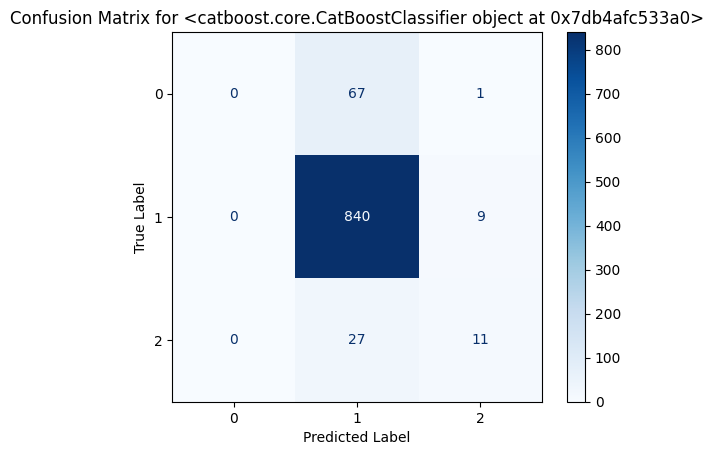

In [ ]:
cb_model = CatBoostClassifier(verbose=0)
cb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
acc_base_cb_valid, prec_base_cb_valid, rec_base_cb_valid, f1_base_cb_valid = evaluate_model(cb_model, X_valid, y_valid)
print_acc("CatBoostClassifier (Base Model - validation set)", acc_base_cb_valid, prec_base_cb_valid, rec_base_cb_valid, f1_base_cb_valid)

# Evaluate the model on the test set
acc_base_cb_test, prec_base_cb_test, rec_base_cb_test, f1_base_cb_test = evaluate_model(cb_model, X_test, y_test)
print_acc("CatBoostClassifier (Base Model - test set)", acc_base_cb_test, prec_base_cb_test, rec_base_cb_test, f1_base_cb_test)

# Plot the confusion matrix
plot_confusion_matrix(cb_model, X_test, y_test)

### Hyperparameter Tuning with GridSearch

In [ ]:
param_grid_cb = {
    'iterations': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8]
}

grid_cb = GridSearchCV(estimator=CatBoostClassifier(silent=True, random_state=42), param_grid=param_grid_cb, cv=5, scoring='accuracy')
grid_cb.fit(X_train, y_train)

print(f"Best CatBoost params: {grid_cb.best_params_}\n")

Best CatBoost params: {'depth': 6, 'iterations': 100, 'learning_rate': 0.1}



CatBoost (Validation)
 - Accuracy: 0.8952879581151832,
 - Precision: 0.8313639734195652,
 - Recall: 0.8952879581151832,
 - F1 Score: 0.8598563218712069

CatBoost (Test)
 - Accuracy: 0.8994764397905759,
 - Precision: 0.8323246633255873,
 - Recall: 0.8994764397905759,
 - F1 Score: 0.8617477212137011



<Figure size 800x600 with 0 Axes>

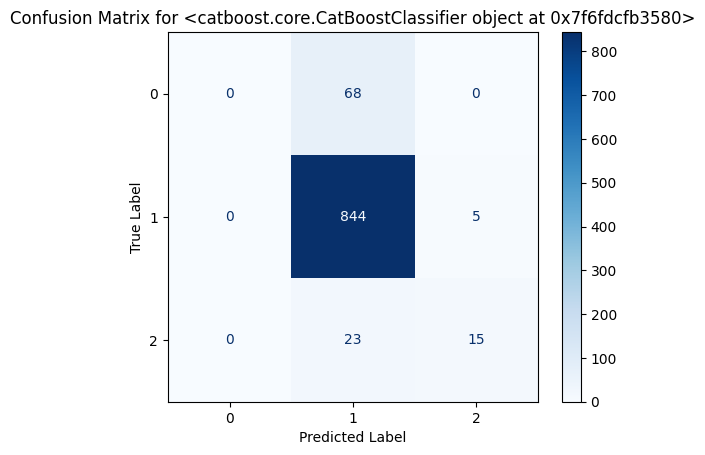

In [ ]:
acc_cb_valid, prec_cb_valid, rec_cb_valid, f1_cb_valid = evaluate_model(grid_cb.best_estimator_, X_valid, y_valid)
print_acc('CatBoost (Validation)', acc_cb_valid, prec_cb_valid, rec_cb_valid, f1_cb_valid)

acc_cb_test, prec_cb_test, rec_cb_test, f1_cb_test = evaluate_model(grid_cb.best_estimator_, X_test, y_test)
print_acc('CatBoost (Test)', acc_cb_test, prec_cb_test, rec_cb_test, f1_cb_test)

plot_confusion_matrix(grid_cb.best_estimator_, X_test, y_test)

### Cross-validation

In [ ]:
pipeline_cb = Pipeline([
    ('estimator', grid_cb.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_cb = cross_val_score(pipeline_cb, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_cb)
print("Mean accuracy:", scores_cb.mean())
print("Standard deviation:", scores_cb.std())

Cross-validation scores: [0.8921466  0.9078534  0.90680628 0.90157068 0.91308901 0.88900524
 0.9026178  0.89842932 0.89947644 0.90251572]
Mean accuracy: 0.9013510487668345
Standard deviation: 0.0067972117613060955


## Decision Tree Classifier

### Basic Model

DecisionTreeClassifier (Base Model)
 - Accuracy: 0.8345549738219895,
 - Precision: 0.8397321738484662,
 - Recall: 0.8345549738219895,
 - F1 Score: 0.8371054637883788

DecisionTreeClassifier (Base Model)
 - Accuracy: 0.8418848167539267,
 - Precision: 0.8403565367107192,
 - Recall: 0.8418848167539267,
 - F1 Score: 0.8409315929357355



<Figure size 800x600 with 0 Axes>

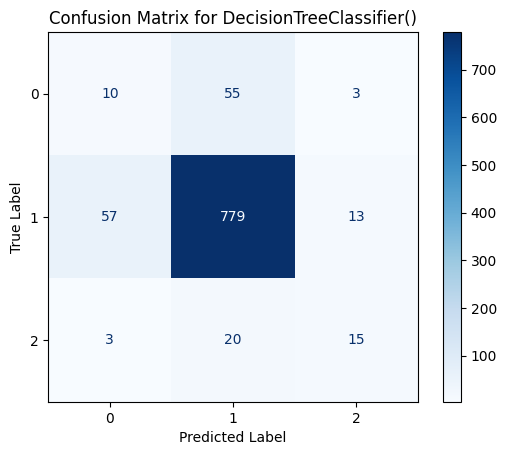

In [ ]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)

acc_base_dt_valid, prec_base_dt_valid, rec_base_dt_valid, f1_base_dt_valid = evaluate_model(dt_model, X_valid, y_valid)
print_acc("DecisionTreeClassifier (Base Model)", acc_base_dt_valid, prec_base_dt_valid, rec_base_dt_valid, f1_base_dt_valid)

acc_base_dt_test, prec_base_dt_test, rec_base_dt_test, f1_base_dt_test = evaluate_model(dt_model, X_test, y_test)
print_acc("DecisionTreeClassifier (Base Model)", acc_base_dt_test, prec_base_dt_test, rec_base_dt_test, f1_base_dt_test)

plot_confusion_matrix(dt_model, X_test, y_test)

### Hyperparameter Tuning with GridSearch

In [ ]:
param_grid_tree = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 10, 20, 30],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4, 10]
}

grid_tree = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid_tree, cv=5, scoring='accuracy')
grid_tree.fit(X_train, y_train)

print(f"Best Decision Tree params: {grid_tree.best_params_}\n")

Best Decision Tree params: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2}



Decision Tree (Validation)
 - Accuracy: 0.8973821989528796,
 - Precision: 0.8328434629365032,
 - Recall: 0.8973821989528796,
 - F1 Score: 0.8577223671692144

Decision Tree (Test)
 - Accuracy: 0.8931937172774869,
 - Precision: 0.8231436190983809,
 - Recall: 0.8931937172774869,
 - F1 Score: 0.8511363593866865



<Figure size 800x600 with 0 Axes>

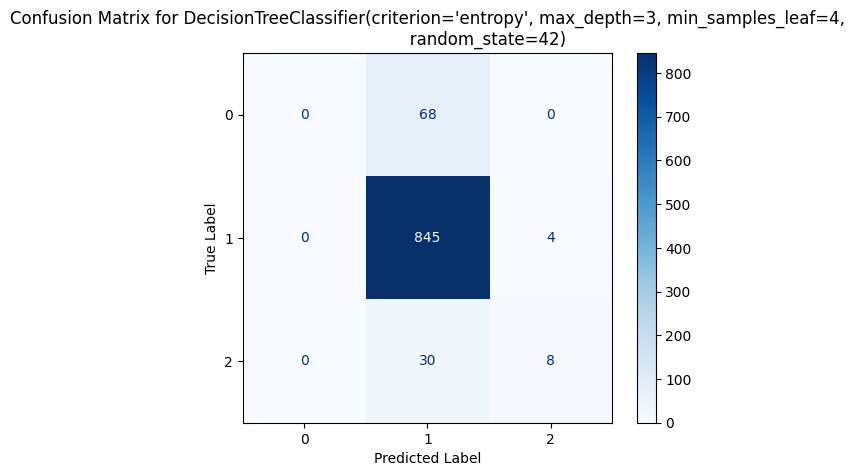

In [ ]:
# Đánh giá mô hình tốt nhất trên tập validation
acc_tree_valid, prec_tree_valid, rec_tree_valid, f1_tree_valid = evaluate_model(grid_tree.best_estimator_, X_valid, y_valid)
print_acc('Decision Tree (Validation)', acc_tree_valid, prec_tree_valid, rec_tree_valid, f1_tree_valid)

# Đánh giá mô hình cuối cùng trên tập test
acc_tree_test, prec_tree_test, rec_tree_test, f1_tree_test = evaluate_model(grid_tree.best_estimator_, X_test, y_test)
print_acc('Decision Tree (Test)', acc_tree_test, prec_tree_test, rec_tree_test, f1_tree_test)

# Vẽ confusion matrix cho tập test
plot_confusion_matrix(grid_tree.best_estimator_, X_test, y_test)

### Cross-validation

In [ ]:
# Chia toàn bộ dữ liệu thành 10 tập để đánh giá cross-validation
pipeline_tree = Pipeline([
    ('estimator', grid_tree.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_tree = cross_val_score(pipeline_tree, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_tree)
print("Mean accuracy:", scores_tree.mean())
print("Standard deviation:", scores_tree.std())

Cross-validation scores: [0.89633508 0.90052356 0.8973822  0.89633508 0.90575916 0.88167539
 0.8973822  0.89842932 0.89109948 0.8951782 ]
Mean accuracy: 0.8960099663033576
Standard deviation: 0.005962674020071489


## LightGBM

### Basic Model

LightGBMClassifier (Base Model)
 - Accuracy: 0.8942408376963351,
 - Precision: 0.8405278453821771,
 - Recall: 0.8942408376963351,
 - F1 Score: 0.8462195971321731

LightGBMClassifier (Base Model)
 - Accuracy: 0.8890052356020942,
 - Precision: 0.7903303089279351,
 - Recall: 0.8890052356020942,
 - F1 Score: 0.8367687860600643



<Figure size 800x600 with 0 Axes>

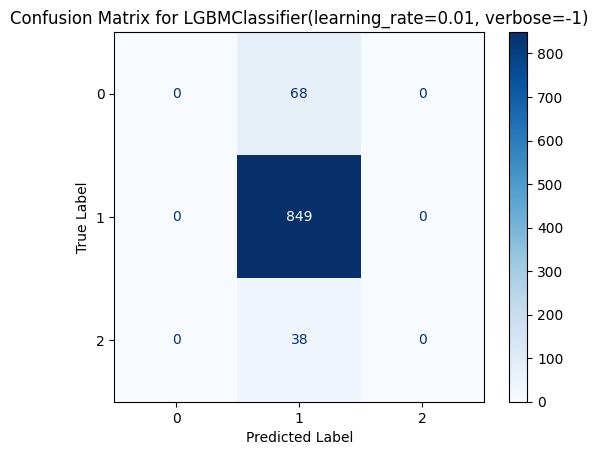

In [ ]:
lgb_model = LGBMClassifier(verbose=-1)
lgb_model.fit(X_train, y_train)

# Evaluate the model on the validation set
acc_base_lgb_valid, prec_base_lgb_valid, rec_base_lgb_valid, f1_base_lgb_valid = evaluate_model(lgb_model, X_valid, y_valid)
print_acc("LightGBMClassifier (Base Model)", acc_base_lgb_valid, prec_base_lgb_valid, rec_base_lgb_valid, f1_base_lgb_valid)

# Evaluate the model on the test set
acc_base_lgb_test, prec_base_lgb_test, rec_base_lgb_test, f1_base_lgb_test = evaluate_model(lgb_model, X_test, y_test)
print_acc("LightGBMClassifier (Base Model)", acc_base_lgb_test, prec_base_lgb_test, rec_base_lgb_test, f1_base_lgb_test)

# Plot the confusion matrix
plot_confusion_matrix(lgb_model, X_test, y_test)

### Hyperparameter Tuning with GridSearch

In [ ]:
param_grid_lgbm = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [10, 20, 30],
    'num_leaves': [10, 20, 50, 100],
    'min_split_gain': [0.05, 0.1, 1],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'subsample': [0.5, 0.8, 1.0],
    'min_child_samples': [80, 100, 150, 200]
}


grid_lgbm = GridSearchCV(
    estimator=LGBMClassifier(random_state=42, verbose=-1),
    param_grid=param_grid_lgbm,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_lgbm.fit(X_train, y_train)

print(f"Best LightGBM params: {grid_lgbm.best_params_}\n")

Best LightGBM params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 20, 'min_child_samples': 100, 'min_split_gain': 0.1, 'n_estimators': 100, 'num_leaves': 50, 'subsample': 0.8}



LightGBM (Validation)
 - Accuracy: 0.8952879581151832,
 - Precision: 0.853033856143725,
 - Recall: 0.8952879581151832,
 - F1 Score: 0.861227092915632

LightGBM (Test)
 - Accuracy: 0.8994764397905759,
 - Precision: 0.8803792778415507,
 - Recall: 0.8994764397905759,
 - F1 Score: 0.8639879828527967



<Figure size 800x600 with 0 Axes>

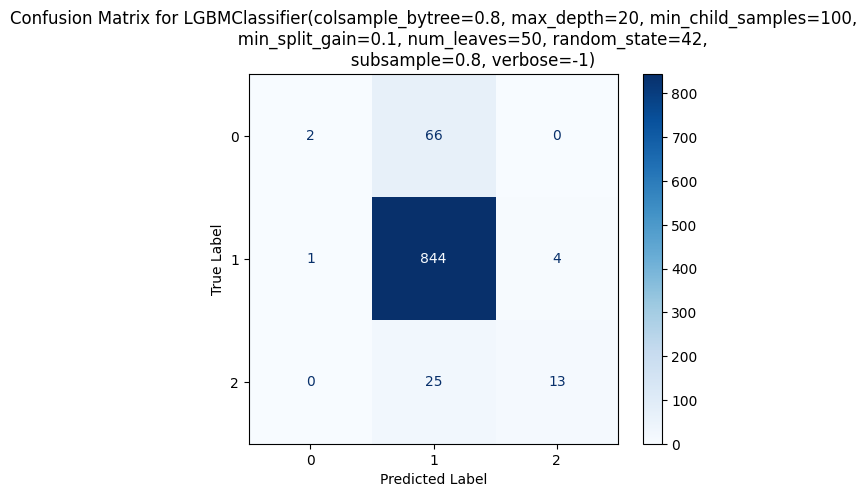

In [ ]:
acc_lgbm_valid, prec_lgbm_valid, rec_lgbm_valid, f1_lgbm_valid = evaluate_model(grid_lgbm.best_estimator_, X_valid, y_valid)
print_acc('LightGBM (Validation)', acc_lgbm_valid, prec_lgbm_valid, rec_lgbm_valid, f1_lgbm_valid)

acc_lgbm_test, prec_lgbm_test, rec_lgbm_test, f1_lgbm_test = evaluate_model(grid_lgbm.best_estimator_, X_test, y_test)
print_acc('LightGBM (Test)', acc_lgbm_test, prec_lgbm_test, rec_lgbm_test, f1_lgbm_test)

plot_confusion_matrix(grid_lgbm.best_estimator_, X_test, y_test)

### Cross-validation

In [ ]:
pipeline_lgbm = Pipeline([
    ('estimator', grid_lgbm.best_estimator_)
])

cv = KFold(n_splits=10, shuffle=True, random_state=42)
scores_lgbm = cross_val_score(pipeline_lgbm, X, y, cv=cv, scoring='accuracy')

print("Cross-validation scores:", scores_lgbm)
print("Mean accuracy:", scores_lgbm.mean())
print("Standard deviation:", scores_lgbm.std())

Cross-validation scores: [0.89109948 0.90366492 0.9078534  0.90052356 0.91099476 0.88376963
 0.9026178  0.89424084 0.89528796 0.90356394]
Mean accuracy: 0.8993616297320732
Standard deviation: 0.007808721719405764


# Evaluation

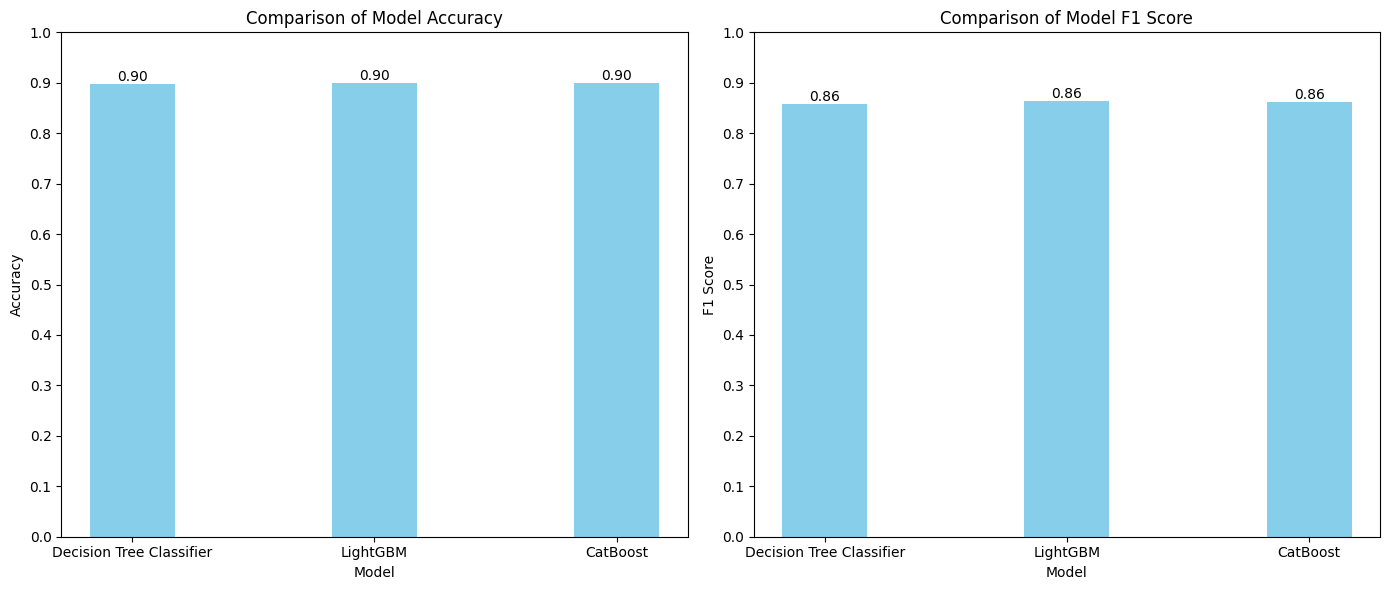

In [ ]:
models = ['Decision Tree Classifier', 'LightGBM', 'CatBoost']
acc = [acc_tree_test, acc_lgbm_test, acc_cb_test]
f1 = [f1_tree_test, f1_lgbm_test, f1_cb_test]
precision = [prec_tree_test, prec_lgbm_test, prec_cb_test]
recall = [rec_tree_test, rec_lgbm_test, rec_cb_test]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['skyblue'] * len(models)
plt.bar(index, acc, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracy')
plt.xticks(index, models, rotation=0)  # Set rotation=0 to make labels straight
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, acc[i], f'{acc[i]:.2f}', ha='center', va='bottom', color='black')

plt.subplot(1, 2, 2)
plt.bar(index, f1, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('Comparison of Model F1 Score')
plt.xticks(index, models, rotation=0)  # Set rotation=0 to make labels straight
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, f1[i], f'{f1[i]:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

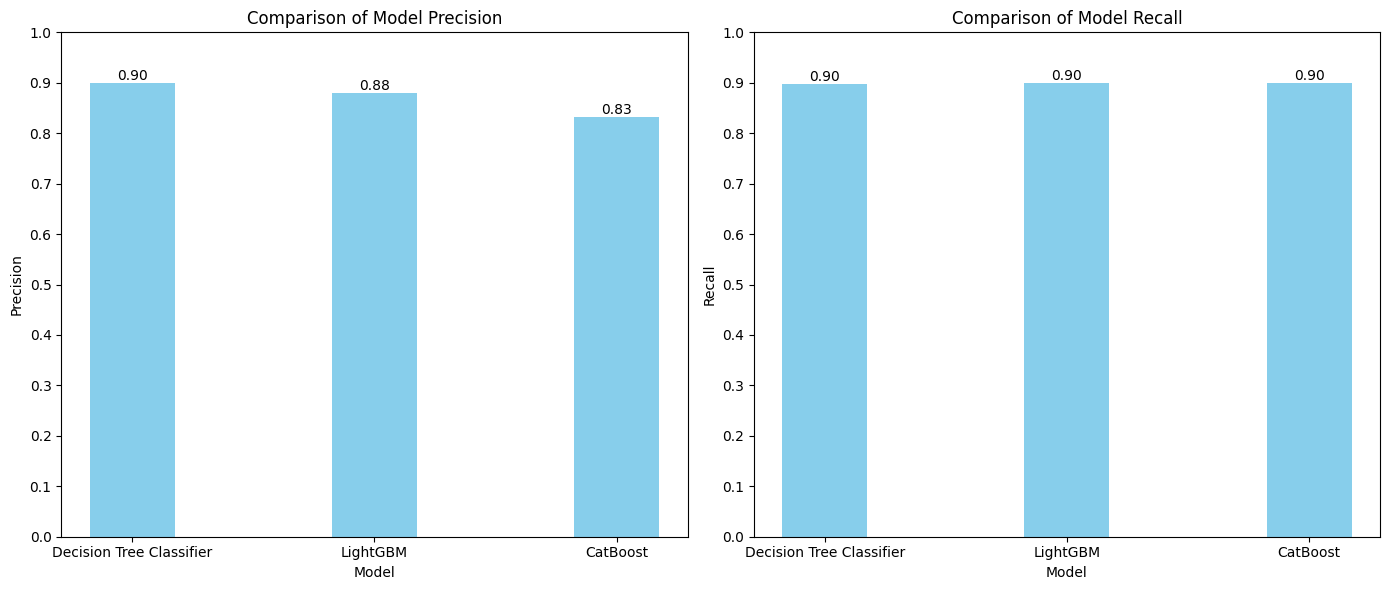

In [ ]:
models = ['Decision Tree Classifier', 'LightGBM', 'CatBoost']
precision = [prec_tree_test, prec_lgbm_test, prec_cb_test]
recall = [rec_tree_test, rec_lgbm_test, rec_cb_test]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
colors = ['skyblue'] * len(models)
plt.bar(index, precision, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('Precision')
plt.title('Comparison of Model Precision')
plt.xticks(index, models, rotation=0)  # Set rotation=0 to make labels straight
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, precision[i], f'{precision[i]:.2f}', ha='center', va='bottom', color='black')

plt.subplot(1, 2, 2)
plt.bar(index, recall, bar_width, color=colors)
plt.xlabel('Model')
plt.ylabel('Recall')
plt.title('Comparison of Model Recall')
plt.xticks(index, models, rotation=0)  # Set rotation=0 to make labels straight
plt.yticks(np.arange(0, 1.1, 0.1))
for i in range(len(models)):
    plt.text(i, recall[i], f'{recall[i]:.2f}', ha='center', va='bottom', color='black')

plt.tight_layout()
plt.show()

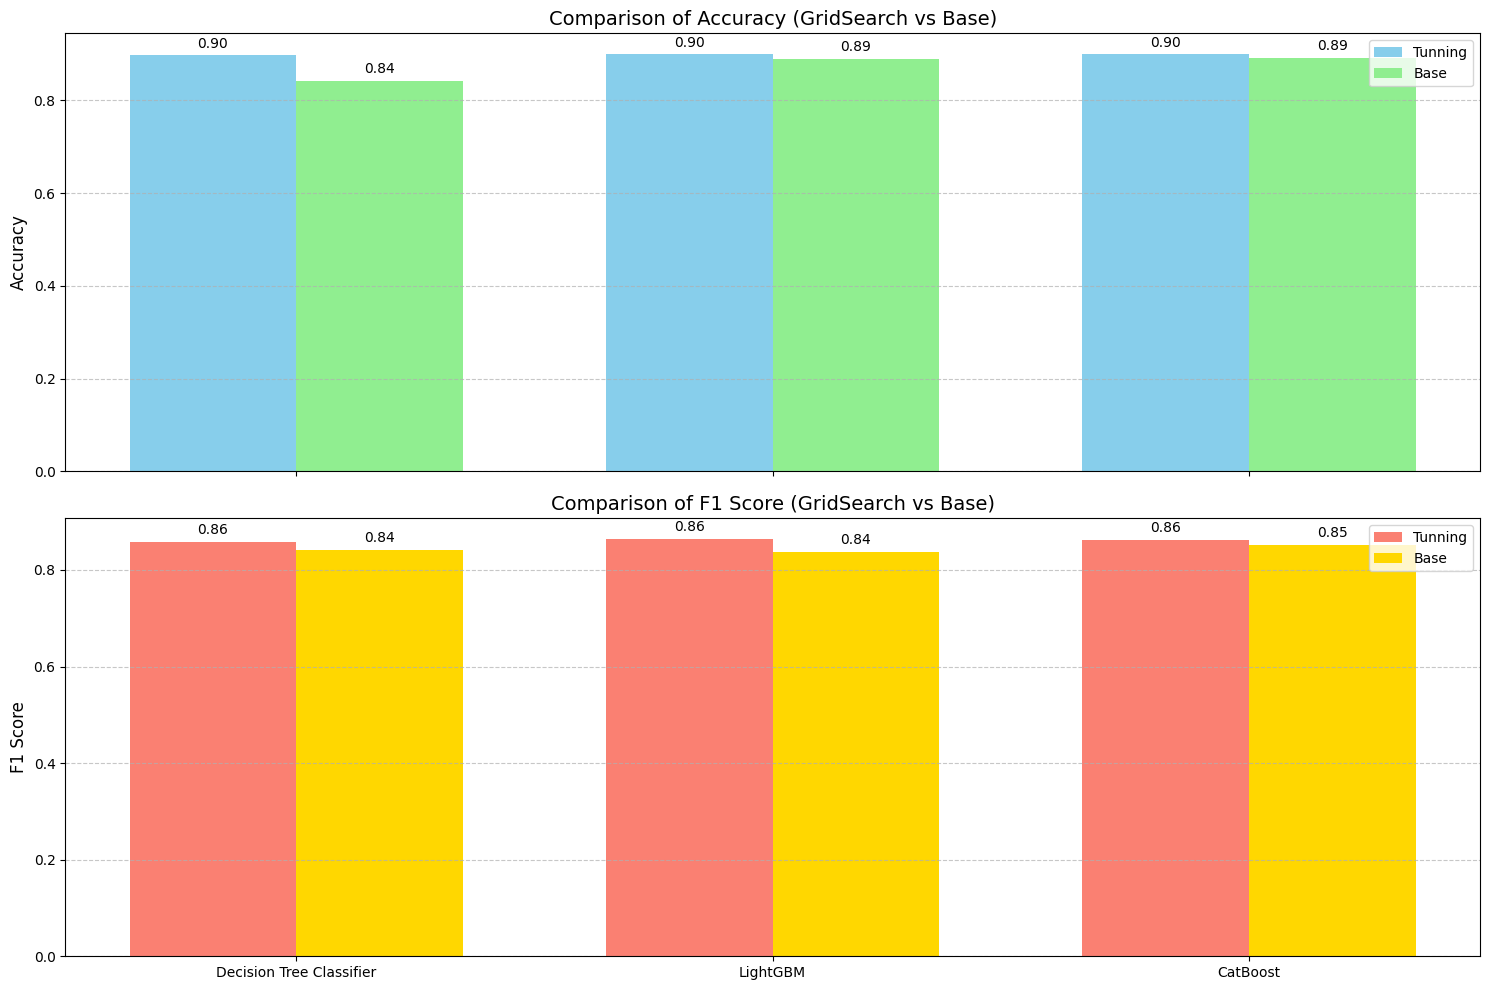

In [ ]:
models = ['Decision Tree Classifier', 'LightGBM', 'CatBoost']
acc = [acc_tree_test, acc_lgbm_test, acc_cb_test]
f1 = [f1_tree_test, f1_lgbm_test, f1_cb_test]
acc_base = [acc_base_dt_test, acc_base_lgb_test, acc_base_cb_test]
f1_base = [f1_base_dt_test, f1_base_lgb_test, f1_base_cb_test]

# Define x for bar positions
x = np.arange(len(models))
bar_width = 0.35

# Create the figure and axes for two subplots
fig, axes = plt.subplots(2, 1, figsize=(15, 10), sharex=True)

# Plot Accuracy comparison
bars1 = axes[0].bar(x - bar_width / 2, acc, bar_width, label='Tunning', color='skyblue')
bars2 = axes[0].bar(x + bar_width / 2, acc_base, bar_width, label='Base', color='lightgreen')
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Comparison of Accuracy (GridSearch vs Base)', fontsize=14)
axes[0].legend(fontsize=10, loc='best')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars for Accuracy
for bar in bars1:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)
for bar in bars2:
    axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Plot F1 Score comparison
bars3 = axes[1].bar(x - bar_width / 2, f1, bar_width, label='Tunning', color='salmon')
bars4 = axes[1].bar(x + bar_width / 2, f1_base, bar_width, label='Base', color='gold')
axes[1].set_ylabel('F1 Score', fontsize=12)
axes[1].set_title('Comparison of F1 Score (GridSearch vs Base)', fontsize=14)
axes[1].legend(fontsize=10, loc='best')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Add labels on the bars for F1 Score
for bar in bars3:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)
for bar in bars4:
    axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01,
                 f'{bar.get_height():.2f}', ha='center', va='bottom', fontsize=10)

# Set x-axis labels
axes[1].set_xticks(x)
axes[1].set_xticklabels(models, fontsize=10, rotation=0)  # Set rotation=0 to make labels straight

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

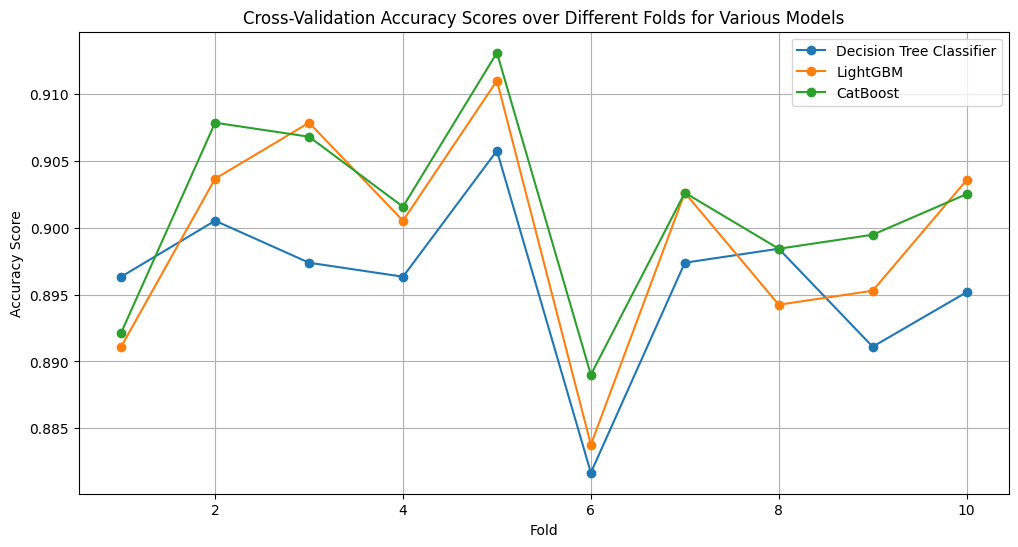

In [ ]:
models = ['Decision Tree Classifier', 'LightGBM', 'CatBoost']
all_scores = [scores_tree, scores_lgbm, scores_cb]

# Plotting
plt.figure(figsize=(12, 6))
for i, scores in enumerate(all_scores):
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=models[i])

plt.xlabel("Fold")
plt.ylabel("Accuracy Score")
plt.title("Cross-Validation Accuracy Scores over Different Folds for Various Models")
plt.legend()
plt.grid(True)
plt.show()

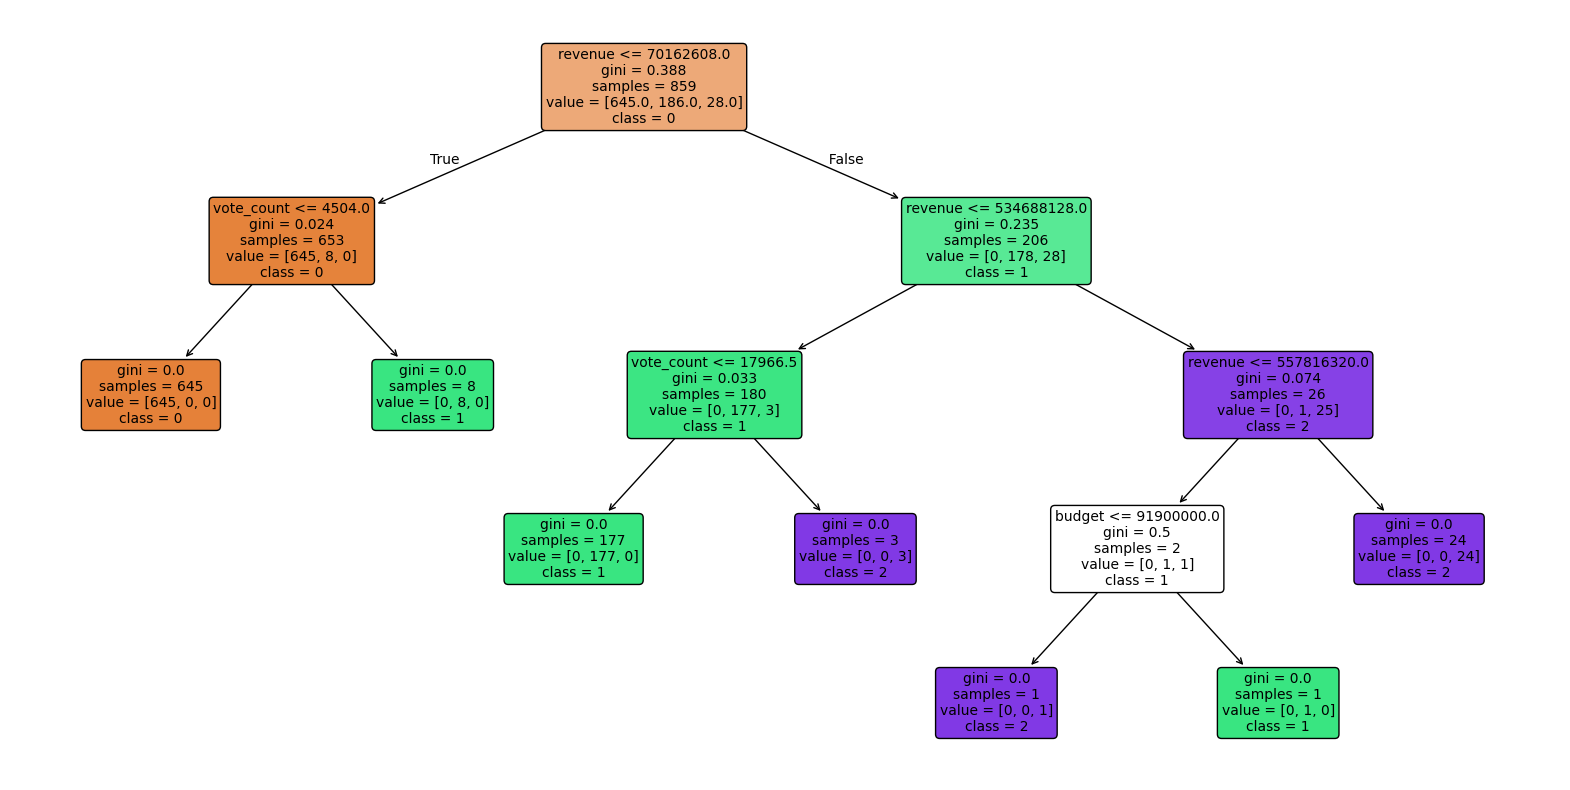

In [ ]:
from sklearn.tree import plot_tree

plt.figure(figsize=(20, 10))
plot_tree(grid_tree.best_estimator_,
          feature_names=['vote_count', 'budget', 'revenue'],
          class_names=[str(i) for i in range(len(y.unique()))],
          filled=True,
          fontsize=10,
          rounded=True)

plt.show()

In [ ]:
path = '/gdrive/MyDrive/IS217.P12_22521072/Data/lgbm_model_results.csv'

dfr = pl.read_csv(path)
dfr = dfr.to_pandas()
dfr.head()

,vote_count,budget,revenue,predicted_cluster
0,114,7230000,1453270,0
1,1254,8700000,47355187,0
2,336,2000000,725131,0
3,42,15000000,5290,0
4,8758,18500000,183316455,1


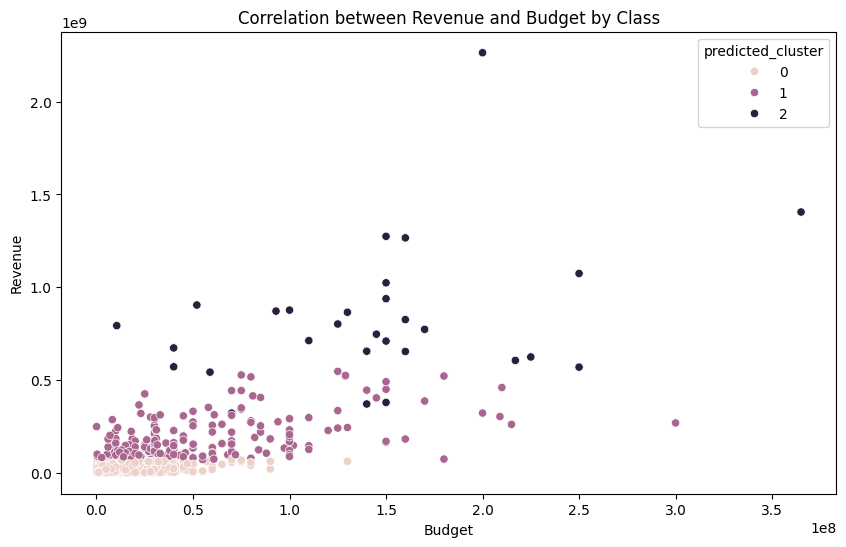

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='budget', y='revenue', hue='predicted_cluster', data=dfr)
plt.title('Correlation between Revenue and Budget by Class')
plt.xlabel('Budget')
plt.ylabel('Revenue')
plt.show()

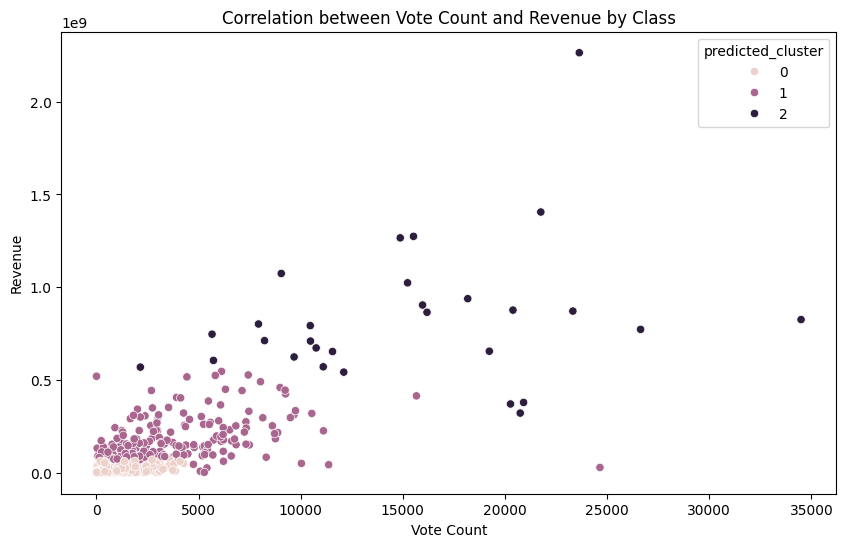

In [ ]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='vote_count', y='revenue', hue='predicted_cluster', data=dfr)
plt.title('Correlation between Vote Count and Revenue by Class')
plt.xlabel('Vote Count')
plt.ylabel('Revenue')
plt.show()